In [1]:
import torch
import torch.nn as nn

from gsp_utils.data import get_data_dgl, pert_S

from arch.model import RobustGNNModel1, RobustGNNModel2

import numpy as np

import matplotlib.pyplot as plt

from utils import GCNN, GAT, MLP, GCNH, test_gcnh

from networkx import from_numpy_array
from dgl import from_networkx

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
assert torch.cuda.is_available()

# Single dataset test

In [3]:
dataset = "CornellDataset"

S, feat, labels, n_class, masks = get_data_dgl(dataset, dev=device)
print("Nodes", S.shape[0])

Nodes 183


In [4]:
n_iters_H = 50
n_epochs = 500
lr = 0.001
wd = 1e-2
eval_freq = 1
es_patience_gcnh = 100
es_patience_rgcnh = 20

lr_S = 1e-3

n_iters = 100
n_iters_S = 10#15

hid_dim = 32
n_layers = 2
bias = True
dropout = 0.25
K = 3
norm_S = True
act = nn.LeakyReLU
batch_norm = False

in_dim = feat.shape[1]
out_dim = n_class

model_params = {
    'in_dim': in_dim,
    'hid_dim': hid_dim,
    'out_dim': out_dim,
    'n_layers': n_layers,
    'act': act,
    'bias': bias,
    'last_act': nn.Softmax(dim=1),
    'dropout': dropout,
    'K': K,
    'norm_S': norm_S,
    'batch_norm': batch_norm
}
model_params_m2 = model_params.copy()
del model_params_m2['K']
del model_params_m2['norm_S']

gamma = 0
beta = 0.1
lambd = 1.

hid_dim_gat = 8
num_heads = 8
gat_params = {
    'feat_drop': 0.6,
    'attn_drop': 0.6
}

In [5]:
eps = 0.0
n_p = 0.3
Sn = pert_S(S, type="rewire_nonsym", eps=eps, n_p_white=n_p)
g = from_networkx(from_numpy_array(Sn)).add_self_loop().to(device)

S = torch.Tensor(S).to(device)
Sn = torch.Tensor(Sn).to(device)

torch.linalg.norm(Sn - S) / torch.linalg.norm(S)

tensor(0.2905, device='cuda:0')

In [6]:
Sn[torch.where(Sn != 0)]

tensor([1.1785, 1.0669, 0.7792, 1.2044, 0.5207, 0.7481, 0.5529, 0.5518, 0.4344,
        0.9524, 0.7462, 0.8866, 0.9334, 0.8277, 0.7463, 1.3122, 1.0533, 1.1097,
        0.8101, 1.2031, 1.0143, 1.3037, 0.7275, 1.3393, 0.9970, 1.0431, 1.0633,
        0.3938, 1.0884, 1.9617, 1.1325, 0.8617, 0.9164, 1.0999, 1.6576, 0.9996,
        0.9103, 0.7584, 0.7708, 1.7376, 0.8465, 0.9993, 0.8836, 0.5810, 1.1021,
        0.8849, 1.0790, 0.8139, 0.8855, 0.5572, 1.1617, 1.1407, 0.5879, 0.8878,
        1.1662, 1.5500, 1.2296, 0.8081, 1.4837, 0.8422, 1.1769, 0.9693, 0.7131,
        0.8003, 0.8659, 0.3851, 1.0634, 1.2955, 0.8277, 1.3941, 1.0052, 0.6366,
        1.3685, 1.0149, 1.1903, 1.5760, 0.9446, 0.8622, 0.5837, 0.5683, 1.3125,
        0.7957, 0.9588, 1.0030, 0.9228, 0.7468, 0.8561, 1.3836, 1.3665, 0.7526,
        1.2377, 1.1069, 0.8544, 1.2795, 0.5836, 0.8274, 0.7065, 1.2842, 0.9371,
        1.3184, 1.0232, 0.5527, 0.9362, 0.3853, 1.1082, 0.7624, 0.8056, 1.0430,
        0.8163, 1.2660, 0.9829, 0.9345, 

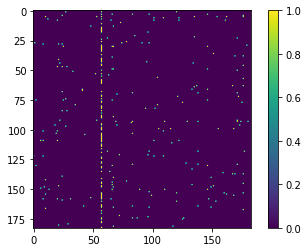

In [7]:
plt.imshow(S.to('cpu').numpy())
plt.colorbar()

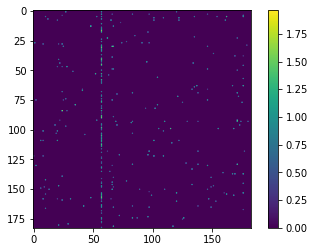

In [8]:
plt.imshow(Sn.to('cpu').numpy())
plt.colorbar()

In [9]:
S_init = Sn.clone()#torch.zeros(Sn.shape, device=device)
model = RobustGNNModel1(S_init, n_iters_H, lr, wd, lr_S, eval_freq, model_params, n_iters, n_iters_S, problem_type="clas", loss_fn=nn.NLLLoss)
model.model = model.model.to(device)

results_dict_m1, S_dict_m1 = model.test_model(Sn, feat, labels, gamma, lambd, beta, train_idx=masks['train'], val_idx=masks['val'], test_idx=masks['test'], norm_S=False, S_true=S, es_patience=es_patience_rgcnh, verbose=True, debug_S=False)

Iteration 1 DONE - Acc Test: 0.6216216216216216 - Err S: 0.6338067650794983
Iteration 2 DONE - Acc Test: 0.6486486486486487 - Err S: 0.6259327530860901
Iteration 3 DONE - Acc Test: 0.7027027027027027 - Err S: 0.618100643157959
Iteration 4 DONE - Acc Test: 0.6756756756756757 - Err S: 0.6103096008300781
Iteration 5 DONE - Acc Test: 0.7027027027027027 - Err S: 0.6025644540786743
Iteration 6 DONE - Acc Test: 0.6756756756756757 - Err S: 0.5948750972747803
Iteration 7 DONE - Acc Test: 0.7027027027027027 - Err S: 0.5872462391853333
Iteration 8 DONE - Acc Test: 0.7297297297297297 - Err S: 0.5796884298324585
Iteration 9 DONE - Acc Test: 0.7027027027027027 - Err S: 0.5722134113311768
Iteration 10 DONE - Acc Test: 0.7027027027027027 - Err S: 0.5648012161254883
Iteration 11 DONE - Acc Test: 0.6756756756756757 - Err S: 0.5574567914009094
Iteration 12 DONE - Acc Test: 0.7567567567567568 - Err S: 0.5501928925514221
Iteration 13 DONE - Acc Test: 0.7567567567567568 - Err S: 0.5429877042770386
Iteration

In [10]:
results_dict_m1['best_acc_test'], model.eval_fn(feat, labels, masks['test']), model.eval_fn(feat, labels, masks['train'])

(0.6486486486486487, 0.7297297297297297, 1.0)

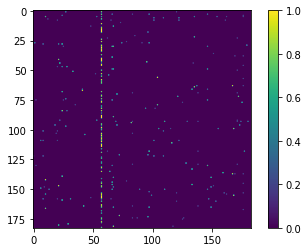

In [11]:
plt.imshow(S_dict_m1['rec_S'].cpu().numpy())
plt.colorbar()

In [12]:
torch.linalg.norm(S_dict_m1['rec_S']), torch.linalg.norm(S)

(tensor(11.7100, device='cuda:0'), tensor(17.2627, device='cuda:0'))

In [13]:
S_init = Sn.clone()#torch.zeros(Sn.shape, device=device)
model = RobustGNNModel2(S_init, n_iters_H, lr, wd, lr_S, eval_freq, model_params_m2, n_iters, n_iters_S, problem_type="clas", loss_fn=nn.NLLLoss)
model.model = model.model.to(device)

results_dict_m2, S_dict_m2 = model.test_model(Sn, feat, labels, gamma, lambd, beta, train_idx=masks['train'], val_idx=masks['val'], test_idx=masks['test'], norm_S=False, S_true=S, es_patience=es_patience_rgcnh, verbose=True, debug_S=False)

Iteration 1 DONE - Acc Test: 0.16216216216216217 - Err S: 0.21697768568992615
Iteration 2 DONE - Acc Test: 0.16216216216216217 - Err S: 0.21697768568992615
Iteration 3 DONE - Acc Test: 0.16216216216216217 - Err S: 0.21697768568992615
Iteration 4 DONE - Acc Test: 0.1891891891891892 - Err S: 0.21697768568992615
Iteration 5 DONE - Acc Test: 0.1891891891891892 - Err S: 0.21697768568992615
Iteration 6 DONE - Acc Test: 0.16216216216216217 - Err S: 0.21697768568992615
Iteration 7 DONE - Acc Test: 0.13513513513513514 - Err S: 0.21697768568992615
Iteration 8 DONE - Acc Test: 0.16216216216216217 - Err S: 0.21697768568992615
Iteration 9 DONE - Acc Test: 0.13513513513513514 - Err S: 0.21697768568992615
Iteration 10 DONE - Acc Test: 0.16216216216216217 - Err S: 0.21697768568992615
Iteration 11 DONE - Acc Test: 0.16216216216216217 - Err S: 0.21697768568992615
Iteration 12 DONE - Acc Test: 0.1891891891891892 - Err S: 0.21697768568992615
Iteration 13 DONE - Acc Test: 0.1891891891891892 - Err S: 0.2169

In [14]:
n_iters_H_gnn = 50
model = RobustGNNModel1(Sn, n_iters_H_gnn, lr, wd, lr_S, eval_freq, model_params, n_iters, n_iters_S, problem_type="clas", loss_fn=nn.NLLLoss)
model.model = model.model.to(device)

_, _, acc_test, _ = model.stepH(
    feat, labels, masks['train'], masks['val'], masks['test'], verbose=True
)

	Epoch (H) 1/50 - Loss: -0.202 - Train Acc: 0.598 - Test Acc: 0.514
	Epoch (H) 2/50 - Loss: -0.233 - Train Acc: 0.609 - Test Acc: 0.459
	Epoch (H) 3/50 - Loss: -0.266 - Train Acc: 0.586 - Test Acc: 0.459
	Epoch (H) 4/50 - Loss: -0.303 - Train Acc: 0.575 - Test Acc: 0.459
	Epoch (H) 5/50 - Loss: -0.348 - Train Acc: 0.586 - Test Acc: 0.432
	Epoch (H) 6/50 - Loss: -0.382 - Train Acc: 0.563 - Test Acc: 0.432
	Epoch (H) 7/50 - Loss: -0.415 - Train Acc: 0.575 - Test Acc: 0.432
	Epoch (H) 8/50 - Loss: -0.444 - Train Acc: 0.575 - Test Acc: 0.459
	Epoch (H) 9/50 - Loss: -0.471 - Train Acc: 0.609 - Test Acc: 0.459
	Epoch (H) 10/50 - Loss: -0.489 - Train Acc: 0.644 - Test Acc: 0.459
	Epoch (H) 11/50 - Loss: -0.504 - Train Acc: 0.678 - Test Acc: 0.459
	Epoch (H) 12/50 - Loss: -0.544 - Train Acc: 0.724 - Test Acc: 0.514
	Epoch (H) 13/50 - Loss: -0.546 - Train Acc: 0.724 - Test Acc: 0.514
	Epoch (H) 14/50 - Loss: -0.562 - Train Acc: 0.747 - Test Acc: 0.514
	Epoch (H) 15/50 - Loss: -0.600 - Train Acc

In [15]:
#model = GCNH(torch.zeros(Sn.shape, device=device), in_dim, hid_dim, out_dim, model_params['K'], dropout=model_params['dropout']).to(device)
model = GCNH(Sn.clone(), **model_params).to(device)

# model training
loss_train, acc_train, acc_test, best_acc_val, best_acc_test = test_gcnh(model, g, feat, labels, masks['train'], masks['val'], masks['test'], n_epochs, lr, wd, es_patience_gcnh, True)
best_acc_test

Epoch 1/500 - Loss Train: 1.6057456731796265 - Acc Train: 0.4712643623352051 - Acc Val: 0.5423728813559322 - Acc Test: 0.4324324429035187
Epoch 4/500 - Loss Train: 1.2865395545959473 - Acc Train: 0.5747126340866089 - Acc Val: 0.576271186440678 - Acc Test: 0.4324324429035187
Epoch 8/500 - Loss Train: 0.9538693428039551 - Acc Train: 0.7816091775894165 - Acc Val: 0.5932203389830508 - Acc Test: 0.5675675868988037
Epoch 12/500 - Loss Train: 0.8018622398376465 - Acc Train: 0.8735632300376892 - Acc Val: 0.5423728813559322 - Acc Test: 0.5405405163764954
Epoch 16/500 - Loss Train: 0.6380288004875183 - Acc Train: 0.8850574493408203 - Acc Val: 0.576271186440678 - Acc Test: 0.5675675868988037
Epoch 20/500 - Loss Train: 0.5107887387275696 - Acc Train: 0.931034505367279 - Acc Val: 0.6271186440677966 - Acc Test: 0.5675675868988037
Epoch 24/500 - Loss Train: 0.4222560226917267 - Acc Train: 0.954023003578186 - Acc Val: 0.6440677966101694 - Acc Test: 0.5945945978164673
Epoch 28/500 - Loss Train: 0.34388

0.6216216216216216

In [16]:
#model = GCNH(torch.zeros(Sn.shape, device=device), in_dim, hid_dim, out_dim, model_params['K'], dropout=model_params['dropout']).to(device)
model = MLP(in_dim, hid_dim, out_dim, dropout=model_params['dropout']).to(device)

# model training
loss_train, acc_train, acc_test, best_acc_val, best_acc_test = test_gcnh(model, g, feat, labels, masks['train'], masks['val'], masks['test'], n_epochs, lr, wd, es_patience_gcnh, True)

Epoch 1/500 - Loss Train: 1.6061434745788574 - Acc Train: 0.4712643623352051 - Acc Val: 0.559322033898305 - Acc Test: 0.37837839126586914
Epoch 4/500 - Loss Train: 1.4337083101272583 - Acc Train: 0.6091954112052917 - Acc Val: 0.5423728813559322 - Acc Test: 0.45945945382118225
Epoch 8/500 - Loss Train: 1.2193288803100586 - Acc Train: 0.6551724076271057 - Acc Val: 0.5423728813559322 - Acc Test: 0.5135135054588318
Epoch 12/500 - Loss Train: 0.9848306775093079 - Acc Train: 0.7011494040489197 - Acc Val: 0.576271186440678 - Acc Test: 0.5135135054588318
Epoch 16/500 - Loss Train: 0.8209691643714905 - Acc Train: 0.7931034564971924 - Acc Val: 0.576271186440678 - Acc Test: 0.5135135054588318
Epoch 20/500 - Loss Train: 0.7013841271400452 - Acc Train: 0.8045976758003235 - Acc Val: 0.6101694915254238 - Acc Test: 0.5135135054588318
Epoch 24/500 - Loss Train: 0.5677101612091064 - Acc Train: 0.8505747318267822 - Acc Val: 0.6440677966101694 - Acc Test: 0.5135135054588318
Epoch 28/500 - Loss Train: 0.49

## Pro-GNN

In [17]:
from deeprobust.graph.defense import GCN, ProGNN

No module named 'torch_sparse'


/home/vtenorio/.local/lib/python3.8/site-packages/deeprobust/graph/defense/__init__.py:15: UserWarning: Please install pytorch geometric if you would like to use the datasets from pytorch geometric. See details in https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html
  warnings.warn("Please install pytorch geometric if you " +


In [18]:
from dataclasses import dataclass

@dataclass
class ProGNNArgs:
    symmetric: bool
    lr: float
    weight_decay: float
    lr_adj: float
    alpha: float
    beta: float
    epochs: int
    only_gcn: bool
    outer_steps: int
    inner_steps: int
    debug: bool
    lambda_: float
    gamma: float
    phi: float

prognn_args = ProGNNArgs(
    symmetric=False,
    lr=0.01,
    weight_decay=5e-4,
    lr_adj=0.01,
    alpha=5e-4,
    beta=1.5,
    epochs=400,
    only_gcn=False,
    outer_steps=1,
    inner_steps=2,
    debug=False,
    lambda_=0,
    gamma=1,
    phi=0
)

In [19]:
# Pro-GNN
model = GCN(nfeat=in_dim,
            nhid=hid_dim,
            nclass=n_class,
            dropout=0.5, device=device)

prognn = ProGNN(model, prognn_args, device)
prognn.fit(feat, Sn, labels, masks['train'], masks['val'])
prognn.test(feat, labels, masks['test'])

/home/vtenorio/.local/lib/python3.8/site-packages/deeprobust/graph/defense/prognn.py:75: UserWarning: If you find the nuclear proximal operator runs too slow, you can modify line 77 to use prox_operators.prox_nuclear_cuda instead of prox_operators.prox_nuclear to perform the proximal on GPU. See details in https://github.com/ChandlerBang/Pro-GNN/issues/1
  warnings.warn("If you find the nuclear proximal operator runs too slow, you can modify line 77 to use prox_operators.prox_nuclear_cuda instead of prox_operators.prox_nuclear to perform the proximal on GPU. See details in https://github.com/ChandlerBang/Pro-GNN/issues/1")


0.5135135135135136

# Exhaustive Tests

In [20]:
EXPS = [
    {
        "dataset": "Cornell",
        "layer": "GCNH",
        "legend": "Cornell-GCNH",
        "fmt": "v-"
    },
    {
        "dataset": "Texas",
        "layer": "GCNH",
        "legend": "Texas-GCNH",
        "fmt": "d-"
    },
    {
        "dataset": "Wisconsin",
        "layer": "GCNH",
        "legend": "Wisconsin-GCNH",
        "fmt": "s-"
    },
#     {
#         "dataset": "Cora",
#         "layer": "GCNH",
#         "legend": "Cora-GCNH",
#         "fmt": "o-"
#     },
    {
        "dataset": "Cornell",
        "layer": "RGFGCN-M1",
        "legend": "Cornell-RGCNH-M1",
        "fmt": "v-"
    },
    {
        "dataset": "Texas",
        "layer": "RGFGCN-M1",
        "legend": "Texas-RGCNH-M1",
        "fmt": "d-"
    },
    {
        "dataset": "Wisconsin",
        "layer": "RGFGCN-M1",
        "legend": "Wisconsin-RGCNH-M1",
        "fmt": "s-"
    },
#     {
#         "dataset": "Cora",
#         "layer": "RGFGCN-M1",
#         "legend": "Cora-RGCNH-M1",
#         "fmt": "o-"
#     },
#     {
#         "dataset": "Cornell",
#         "layer": "RGFGCN-M2",
#         "legend": "Cornell-RGCNH-M2",
#         "fmt": "v-"
#     },
#     {
#         "dataset": "Texas",
#         "layer": "RGFGCN-M2",
#         "legend": "Texas-RGCNH-M2",
#         "fmt": "d-"
#     },
#     {
#         "dataset": "Wisconsin",
#         "layer": "RGFGCN-M2",
#         "legend": "Wisconsin-RGCNH-M2",
#         "fmt": "s-"
#     },
#     {
#         "dataset": "Cora",
#         "layer": "RGFGCN-M2",
#         "legend": "Cora-RGCNH-M2",
#         "fmt": "o-"
#     },
#     {
#         "dataset": "Cornell",
#         "layer": "GCNN",
#         "legend": "Cornell-GCNN",
#         "fmt": "v-"
#     },
#     {
#         "dataset": "Texas",
#         "layer": "GCNN",
#         "legend": "Texas-GCNN",
#         "fmt": "d-"
#     },
#     {
#         "dataset": "Wisconsin",
#         "layer": "GCNN",
#         "legend": "Wisconsin-GCNN",
#         "fmt": "s-"
#     },
#     {
#         "dataset": "Cora",
#         "layer": "GCNN",
#         "legend": "Cora-GCNN",
#         "fmt": "o-"
#     },
#     {
#         "dataset": "Cornell",
#         "layer": "ProGNN",
#         "legend": "Cornell-ProGNN",
#         "fmt": "v-"
#     },
#     {
#         "dataset": "Texas",
#         "layer": "ProGNN",
#         "legend": "Texas-ProGNN",
#         "fmt": "d-"
#     },
#     {
#         "dataset": "Wisconsin",
#         "layer": "ProGNN",
#         "legend": "Wisconsin-ProGNN",
#         "fmt": "s-"
#     },
#     {
#         "dataset": "Cora",
#         "layer": "ProGNN",
#         "legend": "Cora-ProGNN",
#         "fmt": "o-"
#     },
#     {
#         "dataset": "Cornell",
#         "layer": "GAT",
#         "legend": "Cornell-GAT",
#         "fmt": "v-"
#     },
#     {
#         "dataset": "Texas",
#         "layer": "GAT",
#         "legend": "Texas-GAT",
#         "fmt": "d-"
#     },
#     {
#         "dataset": "Wisconsin",
#         "layer": "GAT",
#         "legend": "Wisconsin-GAT",
#         "fmt": "s-"
#     },
#     {
#         "dataset": "Cora",
#         "layer": "GAT",
#         "legend": "Cora-GAT",
#         "fmt": "o-"
#     },
    # {
    #     "dataset": "Cornell",
    #     "layer": "MLP",
    #     "legend": "Cornell-MLP",
    #     "fmt": "v-."
    # },
    # {
    #     "dataset": "Texas",
    #     "layer": "MLP",
    #     "legend": "Texas-MLP",
    #     "fmt": "d-."
    # },
    # {
    #     "dataset": "Wisconsin",
    #     "layer": "MLP",
    #     "legend": "Wisconsin-MLP",
    #     "fmt": "s-."
    # },
]

In [21]:
# EXPS = [
#     {
#         "dataset": "Cornell",
#         "layer": "ProGNN",
#         "legend": "Cornell-RGCNH-M2",
#         "fmt": "v-"
#     },
#     {
#         "dataset": "Texas",
#         "layer": "RGFGCN-M2",
#         "legend": "Texas-RGCNH-M2",
#         "fmt": "d-"
#     },
# ]

In [ ]:
#perts = [0., 0.01, 0.02, 0.05, 0.15]
perts = [0., 0.033, 0.066, 0.1]
n_ps = [0., 0.033, 0.066, 0.1]


n_graphs = 30
n_graphs_cora = 2

accs_test = np.zeros((n_graphs, len(EXPS), len(perts), len(n_ps)))
errs_S = np.zeros((n_graphs, len(EXPS), len(perts), len(n_ps)))
for i, p in enumerate(perts):
    for j, n_p in enumerate(n_ps):

        for k, exp in enumerate(EXPS):

            print(f"Starting pert {p} - n_p {n_p} of exp {exp['dataset']} - {exp['layer']}: ", end="")

            if "Cora" in exp['dataset']:
                n_graphs_exp = n_graphs_cora
            else:
                n_graphs_exp = n_graphs

            for n in range(n_graphs):

                #if exp['dataset'] == "Cornell" or exp['dataset'] == "Texas" or exp['dataset'] == "Wisconsin": # TODO: Implement cross validation properly
                idx = n % 10
                S, feat, labels, n_class, masks = get_data_dgl(exp['dataset'] + "Dataset", dev=device, idx=idx)
                    
                print(f"{n+1} ", end="")
                
                Sn = pert_S(S.copy(), type="rewire_nonsym", eps=p, n_p_white=n_p)
                if p == 0. and n_p == 0.:
                    assert np.all(Sn == S)

                g = from_networkx(from_numpy_array(Sn.copy())).add_self_loop().to(device)

                S = torch.Tensor(S).to(device)
                Sn = torch.Tensor(Sn).to(device)

                if exp['layer'] == "GCNH":
                    # model.n_iters_H = 50
                    # _, _, acc_test, _ = model.stepH(
                    #     feat, labels, masks['train'], masks['val'], masks['test'], verbose=False
                    # )
                    model = GCNH(Sn.clone(), **model_params).to(device)

                    # model training
                    loss_train, acc_train, acc_test, best_acc_val, best_acc_test = test_gcnh(model, g, feat, labels, masks['train'], masks['val'], masks['test'], n_epochs, lr, wd, es_patience_gcnh, False)
                    err_S = torch.linalg.norm(S - Sn) / torch.linalg.norm(S)
                elif exp['layer'] == "RGFGCN-M1":
                    #S_init = torch.zeros(S.shape, device=device)
                    S_init = Sn.clone()
                    model = RobustGNNModel1(S_init, n_iters_H, lr, wd, lr_S, eval_freq, model_params,
                                            n_iters, n_iters_S, problem_type="clas", loss_fn=nn.NLLLoss)
                    model.model = model.model.to(device)
                    results_dict, S_dict = model.test_model(Sn, feat, labels, gamma, lambd, beta,
                                                                train_idx=masks['train'], val_idx=masks['val'], test_idx=masks['test'],
                                                                norm_S=False, S_true=S, es_patience=es_patience_rgcnh, verbose=False
                                                        )
                    best_acc_test = results_dict['best_acc_test']
                    best_acc_val = results_dict['best_acc_val']
                    err_S = S_dict['best_err_S']
                elif exp['layer'] == "RGFGCN-M2":
                    #S_init = torch.zeros(S.shape, device=device)
                    S_init = Sn.clone()
                    model = RobustGNNModel2(S_init, n_iters_H, lr, wd, lr_S, eval_freq, model_params_m2,
                                            n_iters, n_iters_S, problem_type="clas", loss_fn=nn.NLLLoss)
                    model.model = model.model.to(device)
                    results_dict, S_dict = model.test_model(Sn, feat, labels, gamma, lambd, beta,
                                                                train_idx=masks['train'], val_idx=masks['val'], test_idx=masks['test'],
                                                                norm_S=False, S_true=S, es_patience=es_patience_rgcnh, verbose=False
                                                        )
                    best_acc_test = results_dict['best_acc_test']
                    best_acc_val = results_dict['best_acc_val']
                    err_S = S_dict['best_err_S']
                elif exp['layer'] == "MLP":
                    model = MLP(in_dim, hid_dim, out_dim).to(device)

                    # model training
                    loss_train, acc_train, acc_test, best_acc_val, best_acc_test = test_gcnh(model, g, feat, labels, masks['train'], masks['val'], masks['test'], n_epochs, lr, wd, es_patience_gcnh, False)
                    err_S = torch.linalg.norm(S - Sn) / torch.linalg.norm(S)

                elif exp['layer'] == "GCNN":
                    model = GCNN(in_dim, hid_dim, out_dim).to(device)

                    # model training
                    loss_train, acc_train, acc_test, best_acc_val, best_acc_test = test_gcnh(model, g, feat, labels, masks['train'], masks['val'], masks['test'], n_epochs, lr, wd, es_patience_gcnh, False)
                    err_S = torch.linalg.norm(S - Sn) / torch.linalg.norm(S)
                elif exp['layer'] == "GAT":
                    model = GAT(in_dim, hid_dim_gat, out_dim, num_heads, gat_params).to(device)

                    # model training
                    loss_train, acc_train, acc_test, best_acc_val, best_acc_test = test_gcnh(model, g, feat, labels, masks['train'], masks['val'], masks['test'], n_epochs, lr, wd, es_patience_gcnh, False)
                    err_S = torch.linalg.norm(S - Sn) / torch.linalg.norm(S)
                elif exp['layer'] == "ProGNN":
                    model = GCN(nfeat=in_dim,
                                nhid=hid_dim,
                                nclass=n_class,
                                dropout=0.5, device=device)

                    prognn = ProGNN(model, prognn_args, device)
                    prognn.fit(feat, Sn, labels, masks['train'], masks['val'])
                    best_acc_test = prognn.test(feat, labels, masks['test'])
                    err_S = torch.linalg.norm(S - Sn) / torch.linalg.norm(S)
                #print(acc_test[-1], end=" ")
                accs_test[n, k, i, j] = best_acc_test
                errs_S[n, k, i, j] = err_S
            print(f"DONE - Accuracy Test: {np.mean(accs_test, 0)[k, i, j]:.5f}")

Starting pert 0.0 - n_p 0.0 of exp Cornell - GCNH: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 DONE - Accuracy Test: 0.69099
Starting pert 0.0 - n_p 0.0 of exp Texas - GCNH: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 DONE - Accuracy Test: 0.76126
Starting pert 0.0 - n_p 0.0 of exp Wisconsin - GCNH: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 DONE - Accuracy Test: 0.75556
Starting pert 0.0 - n_p 0.0 of exp Cornell - RGFGCN-M1: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 DONE - Accuracy Test: 0.71982
Starting pert 0.0 - n_p 0.0 of exp Texas - RGFGCN-M1: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 DONE - Accuracy Test: 0.79009
Starting pert 0.0 - n_p 0.0 of exp Wisconsin - RGFGCN-M1: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 DONE - Accuracy Test: 0.78170
Starting pert

In [ ]:
datasets = ["Cornell", "Texas", "Wisconsin"]

fig, ax = plt.subplots(2,3,figsize=(12,8))

for i, exp in enumerate(EXPS):
    idx = datasets.index(exp["dataset"])
    idx_exp = 0 if exp['layer'] == 'GCNH' else 1
    im = ax[idx_exp, idx].imshow(np.mean(accs_test, 0)[i,:,:])
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)


In [ ]:
for i, exp in enumerate(EXPS):
    plt.plot(perts, accs_test.mean(0)[i,:], exp["fmt"], label=exp["legend"])

plt.xlabel("Percentage of links modified", fontsize=12)
plt.ylabel("Accuracy over the test dataset", fontsize=12)
plt.title("Effect of perturbations on the performance of a GNN", fontsize=16)
plt.legend()
plt.grid()

In [ ]:
datasets = ["Cornell", "Texas", "Wisconsin"]

f, ax = plt.subplots(1,len(datasets), figsize=(12,6))

for i, exp in enumerate(EXPS):
    idx = datasets.index(exp["dataset"])
    ax[idx].plot(perts, accs_test.mean(0)[i,:], exp["fmt"], label=exp["legend"])

for i, d in enumerate(datasets):
    ax[i].set_title(d)
    ax[i].set_xlabel("Percentage of links modified")

f.legend()

In [ ]:
if False:
    with open('results/20231023-gaussian.csv', 'w') as f:
        f.write("Pert;" + ';'.join([exp['legend'] for exp in EXPS]) + "\n")
        for i in range(len(perts)):
            f.write(str(perts[i]) + ';' + ';'.join([str(accs_test.mean(0)[j,i]) for j in range(len(EXPS))]) + '\n')

In [ ]:
for i, exp in enumerate(EXPS):
    plt.plot(perts, errs_S.mean(0)[i,:], exp["fmt"], label=exp["legend"])

plt.xlabel("Percentage of links modified", fontsize=12)
plt.ylabel("Error on the recovered S", fontsize=12)
plt.title("Effect of perturbations on the graph denoising", fontsize=16)
plt.legend()
plt.grid()